In [1]:
import re
import string
import numpy as np
import pandas as pd
from functools import reduce
from math import log

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

#own Kmeans
from kmeans_algorithm import Kmeans

In [2]:
corpus = """
Simple example with Cats and Mouse
Another simple example with dogs and cats and more cats
Another simple example with mouse and cheese
""".split("\n")[1:-1]

In [5]:
# clearing and tokenizing
l_A = corpus[0].lower().split()
l_B = corpus[1].lower().split()
l_C = corpus[2].lower().split()

# Calculating bag of words
word_set = set(l_A).union(set(l_B)).union(set(l_C))
print(word_set)

word_dict_A = dict.fromkeys(word_set, 0)
word_dict_B = dict.fromkeys(word_set, 0)
word_dict_C = dict.fromkeys(word_set, 0)

for word in l_A:
    word_dict_A[word] += 1

for word in l_B:
    word_dict_B[word] += 1

for word in l_C:
    word_dict_C[word] += 1

docs_df = pd.DataFrame({'doc': corpus})

wordcount_DF = pd.DataFrame([word_dict_A, word_dict_B, word_dict_C])

#Join titles name
testjoindf = docs_df.join(wordcount_DF)
wordcount_DF

{'with', 'dogs', 'cats', 'cheese', 'and', 'another', 'example', 'mouse', 'more', 'simple'}


,with,dogs,cats,cheese,and,another,example,mouse,more,simple
0,1,0,1,0,1,0,1,1,0,1
1,1,1,2,0,2,1,1,0,1,1
2,1,0,0,1,1,1,1,1,0,1


In [4]:
def compute_tf(word_dict, l):
    tf = {}
    sum_nk = len(l)
    for word, count in word_dict.items():
        tf[word] = count/sum_nk
    return tf
  
tf_A = compute_tf(word_dict_A, l_A)
tf_B = compute_tf(word_dict_B, l_B)
tf_C = compute_tf(word_dict_C, l_C)

In [6]:
def compute_idf(strings_list):
    n = len(strings_list)
    idf = dict.fromkeys(strings_list[0].keys(), 0)
    for l in strings_list:
        for word, count in l.items():
            if count > 0:
                idf[word] += 1
    
    for word, v in idf.items():
        idf[word] = log(n / float(v))
    return idf
#Se lo calcula una sola vez
idf = compute_idf([word_dict_A, word_dict_B, word_dict_C])

In [7]:
def compute_tf_idf(tf, idf):
    tf_idf = dict.fromkeys(tf.keys(), 0)
    for word, v in tf.items():
        tf_idf[word] = v * idf[word]
    return tf_idf
    
tf_idf_A = compute_tf_idf(tf_A, idf)
tf_idf_B = compute_tf_idf(tf_B, idf)
tf_idf_C = compute_tf_idf(tf_C, idf)

dataTf_Idf = pd.DataFrame([tf_idf_A, tf_idf_B, tf_idf_C])
dataTf_Idf

,and,cats,mouse,simple,another,more,example,cheese,with,dogs
0,0.0,0.067578,0.067578,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,0.0,0.081093,0.000000,0.0,0.040547,0.109861,0.0,0.000000,0.0,0.109861
2,0.0,0.000000,0.057924,0.0,0.057924,0.000000,0.0,0.156945,0.0,0.000000


In [1]:
#comienza implementación de prueba con algoritmo propio
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(dataTf_Idf)
test_e = Kmeans(2, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

#visualizador de palabras

def get_top_features_cluster(dataTf_Idf, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(predicted_values==label) # indices for each cluster
        print(id_temp)
        print(label)
        x_means = np.mean(dataTf_Idf[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

dfs = get_top_features_cluster(dataTf_Idf, predicted_values,10)


'''
for d in dfs:
    height = [h[1] for h in d.values]
    bars = [h[0] for h in d.values]
    y_pos = np.arange(len(bars))
    plt.barh(y_pos, height)
    plt.yticks(y_pos, bars)
    plt.show()
'''

NameError: name 'PCA' is not defined

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
   data_index  cluster
0           0        1
1           1        1
2           2        0
(array([2]),)
0
(array([0, 1]),)
1


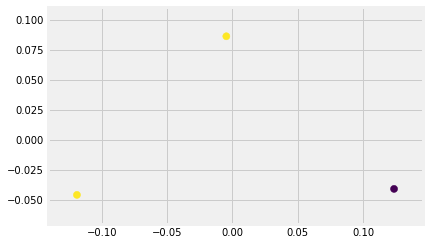

In [17]:
#implementación k-means library
from sklearn.cluster import KMeans
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(dataTf_Idf)
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)
print(fitted)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = docs_df.index.values
cluster_map['cluster'] = fitted.labels_
print(cluster_map)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')

def get_top_features_cluster(dataTf_Idf, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        print(id_temp)
        print(label)
        
    return dfs

dfs = get_top_features_cluster(dataTf_Idf, prediction,10)